KML-File Processing

In [3]:
import os
import pandas as pd
from lxml import etree

# Folder where your KML files are located
KML_FOLDER = "KML_Files"

# Initialize a list to store shelter data
shelters = []

# Define KML namespace
kml_ns = {'kml': 'http://www.opengis.net/kml/2.2'}

# Iterate over all .kml files in the folder
for filename in os.listdir(KML_FOLDER):
    if filename.lower().endswith('.kml'):
        file_path = os.path.join(KML_FOLDER, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            kml_content = f.read()
        root = etree.XML(kml_content.encode('utf-8'))
        placemarks = root.xpath('.//kml:Placemark', namespaces=kml_ns)
        for pm in placemarks:
            shelter = {}
            # Get shelter name
            name_elem = pm.find('.//{http://www.opengis.net/kml/2.2}name')
            shelter['Shelter Name'] = name_elem.text if name_elem is not None else None

            # Extract ExtendedData fields into a dict
            data_elems = pm.xpath('.//kml:ExtendedData/kml:Data', namespaces=kml_ns)
            data_map = {}
            for d in data_elems:
                key = d.get('name')
                value_elem = d.find('.//{http://www.opengis.net/kml/2.2}value')
                data_map[key] = value_elem.text if value_elem is not None else ""

            # Map your fields (adjust names if needed)
            shelter['Type'] = data_map.get('類別', '')
            shelter['Capacity'] = data_map.get('可容納人數', '')
            shelter['LatitudeLongitude'] = data_map.get('緯經度', '')
            # If you want, also store other fields like 地址, 電腦編號, etc.
            shelter['Address'] = data_map.get('地址', '')

            # Extract coordinates from <Point><coordinates>
            coords_elems = pm.xpath('.//kml:Point/kml:coordinates', namespaces=kml_ns)
            if coords_elems:
                coords_text = coords_elems[0].text.strip()
                parts = coords_text.split(',')
                if len(parts) >= 2:
                    shelter['Longitude'] = parts[0]
                    shelter['Latitude'] = parts[1]
                else:
                    shelter['Longitude'] = None
                    shelter['Latitude'] = None
            else:
                shelter['Longitude'] = None
                shelter['Latitude'] = None

            shelters.append(shelter)

# Create a DataFrame
df_shelters = pd.DataFrame(shelters)
display(df_shelters)
#print("DataFrame shape:", df_shelters.shape)
#df_shelters.head()

,Shelter Name,Type,Capacity,LatitudeLongitude,Address,Longitude,Latitude
0,汎洋工程開發大樓,一般住宅,284.0,"25.04989,121.540836",臺北市中山區朱崙街30號,121.540836,25.04989
1,慧日講堂大樓,一般住宅,826.0,"25.0499,121.541289",臺北市中山區朱崙街36號,121.541289,25.0499
2,私人住宅大樓,一般住宅,328.0,"25.048898,121.540541",臺北市中山區龍江路39-43號,121.540541,25.048898
3,私人住宅大樓,一般住宅,354.0,"25.049467,121.540553",臺北市中山區龍江路53號,121.540553,25.049467
4,公寓,一般住宅,514.0,"25.049247,121.541073",臺北市中山區龍江路45巷13-17號,121.541073,25.049247
...,...,...,...,...,...,...,...
22351,親子愛家,一般住宅,111.0,"25.02407,121.511501",臺北市萬華區中華路二段680號,121.511501,25.02407
22352,南海儒家,一般住宅,111.0,"25.024567,121.509398",臺北市萬華區中華路二段596巷2號,121.509398,25.024567
22353,南海儒家,一般住宅,573.0,"25.023755,121.509945",臺北市萬華區中華路二段606巷3號,121.509945,25.023755
22354,國興社區,一般住宅,218.0,"25.023776,121.509047",臺北市萬華區國興路1巷9號,121.509047,25.023776


Data Cleaning

In [4]:
# Convert Capacity, Latitude, and Longitude to numeric values
df_shelters['Capacity'] = pd.to_numeric(df_shelters['Capacity'], errors='coerce')
df_shelters['Latitude'] = pd.to_numeric(df_shelters['Latitude'], errors='coerce')
df_shelters['Longitude'] = pd.to_numeric(df_shelters['Longitude'], errors='coerce')

# Strip extra spaces from Shelter Name (if any)
df_shelters['Shelter Name'] = df_shelters['Shelter Name'].str.strip()

# Check for missing values
print("Missing values per column:")
print(df_shelters.isnull().sum())

# Identify shelters with missing Latitude or Longitude
missing_coords = df_shelters[df_shelters['Latitude'].isna() | df_shelters['Longitude'].isna()]
print("Shelters with missing coordinates:")
display(missing_coords)

Missing values per column:
Shelter Name          0
Type                  0
Capacity              0
LatitudeLongitude     0
Address               0
Longitude            20
Latitude             20
dtype: int64
Shelters with missing coordinates:


,Shelter Name,Type,Capacity,LatitudeLongitude,Address,Longitude,Latitude
8265,公寓,,53.0,"25.111785,121.561947",臺北市士林區至善路三段19號,NaN,NaN
8266,公寓,,84.0,"25.112677,121.561149",臺北市士林區至善路三段7巷1號,NaN,NaN
8267,大樓,,846.0,"25.113643,121.567854",臺北市士林區至善路三段100號,NaN,NaN
8268,福安國中,,1569.0,"25.103352,121.487396",臺北市士林區延平北路七段250號,NaN,NaN
8269,福安國中,,2169.0,"25.103352,121.487396",臺北市士林區延平北路七段250號,NaN,NaN
14620,捷運台北車站,,41366.0,"25.047066,121.51767",臺北市中正區忠孝西路一段49號,NaN,NaN
14621,捷運善導寺站,,19817.0,"25.044554,121.523529",臺北市中正區忠孝東路一段58號,NaN,NaN
14625,捷運台電大樓站,,11548.0,"25.02061,121.527697",臺北市中正區羅斯福路三段126之5號,NaN,NaN
14626,捷運公館站,,14500.0,"25.014289,121.534509",臺北市中正區羅斯福路四段74號,NaN,NaN
14627,捷運台北101/世貿站,,17813.0,"25.0330461661484,121.563273833278",臺北市信義區信義路五段20號,NaN,NaN


In [5]:
# Fill missing Latitude and Longitude using the LatitudeLongitude field if available
def fill_missing_coords(row):
    if pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        if pd.notnull(row['LatitudeLongitude']):
            parts = row['LatitudeLongitude'].split(',')
            if len(parts) >= 2:
                try:
                    # Assuming the format is "latitude,longitude"
                    row['Latitude'] = float(parts[0].strip())
                    row['Longitude'] = float(parts[1].strip())
                except ValueError:
                    pass
    return row

df_shelters = df_shelters.apply(fill_missing_coords, axis=1)

# Verify that missing values have been filled
print("Missing values after filling:")
print(df_shelters.isnull().sum())

# Optionally, display the rows that were missing coordinates before
missing_before = df_shelters[df_shelters['LatitudeLongitude'].notnull() &
                             (df_shelters['Latitude'].isna() | df_shelters['Longitude'].isna())]
print("Rows still missing coordinates:")
display(missing_before)

Missing values after filling:
Shelter Name         0
Type                 0
Capacity             0
LatitudeLongitude    0
Address              0
Longitude            0
Latitude             0
dtype: int64
Rows still missing coordinates:


,Shelter Name,Type,Capacity,LatitudeLongitude,Address,Longitude,Latitude


Gongguan Basemap


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: C:\Users\wasch\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


Shelters inside polygon: 150


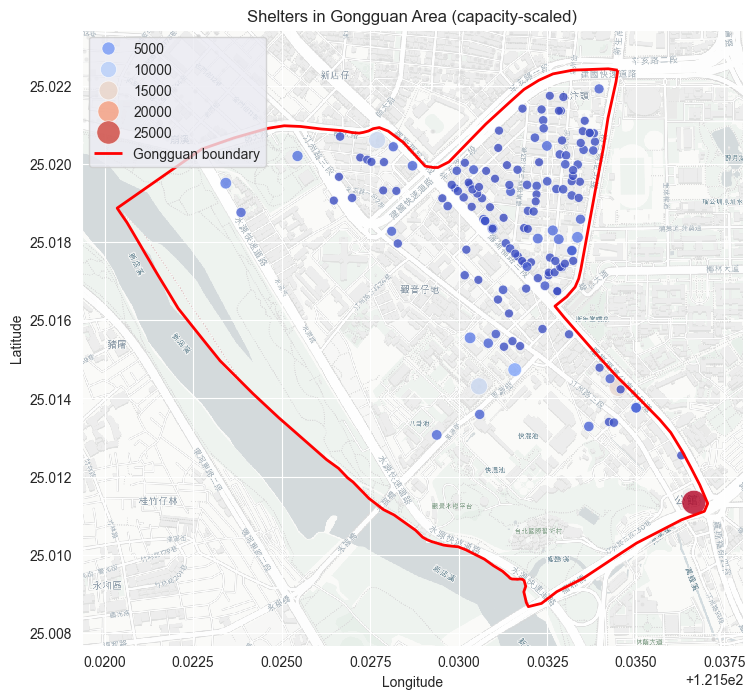

In [6]:
# Make sure contextily is available
!pip install contextily

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import shapely.geometry as geom
import geopandas as gpd
import pandas as pd

# ── 1)  Hand-drawn Gongguan polygon  ───────────────────────────────────────────
gongguan_poly = geom.Polygon([
    (121.53449138386917, 25.022398428845218),
    (121.534224,          25.022434),
    (121.533223,          25.022400),
    (121.532662,          25.022304),
    (121.532260,          25.022139),
    (121.531842,          25.021905),
    (121.531456,          25.021592),
    (121.530765,          25.021019),
    (121.529725,          25.020052),
    (121.529413,          25.019908),
    (121.529285,          25.019908),
    (121.529056,          25.019942),
    (121.528437,          25.020549),
    (121.528008,          25.020840),
    (121.527758,          25.020930),
    (121.527583,          25.020901),
    (121.527454,          25.020843),
    (121.527306,          25.020807),
    (121.527188,          25.020788),
    (121.526996,          25.020802),
    (121.526704,          25.020852),
    (121.526124,          25.020893),
    (121.525536,          25.020958),
    (121.525072,          25.020976),
    (121.524594,          25.020908),
    (121.523661,          25.020667),
    (121.522740,          25.020378),
    (121.520356,          25.018869),
    (121.520441,          25.018753),
    (121.520532,          25.018632),
    (121.520635,          25.018497),
    (121.520711,          25.018380),
    (121.520797,          25.018248),
    (121.520896,          25.018095),
    (121.521017,          25.017909),
    (121.521151,          25.017699),
    (121.521284,          25.017497),
    (121.52139683513222,  25.017321083952876),
    (121.52152692219995,  25.01712481571351),
    (121.52166572653778,  25.01691821729868),
    (121.52183202349208,  25.016671513970774),
    (121.52207878655788,  25.016301458064984),
    (121.52228799886385,  25.016063260509572),
    (121.52254347929293,  25.015772804823186),
    (121.52287204992781,  25.01540092328766),
    (121.52318184512468,  25.015052131377505),
    (121.52326164094326,  25.014962198850014),
    (121.52353589680098,  25.014713668667213),
    (121.52382155173063,  25.01445480764932),
    (121.52419169680184,  25.014119989273265),
    (121.52460073364763,  25.013773624336658),
    (121.52492259887605,  25.013502000715917),
    (121.52517070286771,  25.01330572613356),
    (121.52534907010912,  25.01316414125727),
    (121.52559516239435,  25.012967865956924),
    (121.52585466648392,  25.012761868569996),
    (121.52626772498245,  25.01243312024787),
    (121.52660836358655,  25.01220949713773),
    (121.5268631731263,   25.011966430126265),
    (121.52701605797574,  25.01185947932713),
    (121.52746399229112,  25.01144140874972),
    (121.52787436950295,  25.01115458671468),
    (121.5281801404882,   25.011013605195075),
    (121.52878363889825,  25.01062469749695),
    (121.52898212213547,  25.010447256121815),
    (121.52909477471313,  25.010388919029744),
    (121.52923424931778,  25.01033544313652),
    (121.52957220707677,  25.010245505416563),
    (121.52970095303199,  25.010228489606085),
    (121.52998526732313,  25.010201749453056),
    (121.53020252596824,  25.01012396465772),
    (121.53072555778024,  25.00988576254611),
    (121.5309830488873,   25.009718042340992),
    (121.53123785763907,  25.009577059367693),
    (121.53140951779199,  25.009438507252987),
    (121.53145243275571,  25.009397184703698),
    (121.53150607673226,  25.00937773845326),
    (121.53166164479815,  25.009370444653356),
    (121.53172870016074,  25.009377736030853),
    (121.53180648419756,  25.00936558151085),
    (121.53184671706755,  25.009336412392532),
    (121.53189231304904,  25.009190568679607),
    (121.53183867383225,  25.00904959419308),
    (121.53188695248079,  25.00886485879951),
    (121.53190840960622,  25.008777352535038),
    (121.53196741742157,  25.00867040016833),
    (121.53233756231396,  25.00875304195734),
    (121.53277208444601,  25.009054447707157),
    (121.53351773718047,  25.009397188623424),
    (121.53463086550973,  25.010065629363282),
    (121.53502245689069,  25.01029655297774),
    (121.53629383237106,  25.010892070013576),
    (121.53693755595663,  25.01111083268188),
    (121.53703143548238,  25.011310148803638),
    (121.53680880932662,  25.01178413061182),
    (121.536551316508,    25.01223866653605),
    (121.53631796634721,  25.01263486628669),
    (121.53598805271987,  25.01312585746739),
    (121.5356795993202,   25.01345399611164),
    (121.53492053356604,  25.014154018441296),
    (121.53448065092716,  25.014545348419908),
    (121.53390934022309,  25.015111681786873),
    (121.53297592816718,  25.016076630790938),
    (121.53271843924814,  25.016361007597133),
    (121.53305103397365,  25.01660163444076),
    (121.53328707043308,  25.01684955295716),
    (121.5333889964901,   25.01706344389905),
    (121.53344799834909,  25.01729677821912),
    (121.53386374436191,  25.019350587734177),
    (121.53408636882772,  25.020412722868457),
    (121.53421511296621,  25.0211686061899),
    (121.53444310209994,  25.022104340867333),
    (121.53449138386917,  25.022398428845218)
])
gongguan_gdf = gpd.GeoDataFrame(
    pd.DataFrame({"name":["Gongguan"]}),
    geometry=[gongguan_poly],
    crs="EPSG:4326"
)

# ── 2)  Shelters GeoDataFrame  ────────────────────────────────────────────────
points_gdf = gpd.GeoDataFrame(
    df_shelters,
    geometry=gpd.points_from_xy(df_shelters.Longitude, df_shelters.Latitude),
    crs="EPSG:4326"
)

mask = points_gdf.geometry.within(gongguan_poly)
df_shelters_gongguan = df_shelters[mask].copy()
gdf_gongguan_pts = points_gdf[mask]

print(f"Shelters inside polygon: {len(gdf_gongguan_pts)}")

# ── 3)  Plot  ─────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 8))
ax = plt.gca()

# All shelters (light grey, small)
sns.scatterplot(
    data=points_gdf, x='Longitude', y='Latitude',
    color='lightgrey', s=10, alpha=0.4, ax=ax, legend=False
)

# Gongguan-only shelters (blue, sized by capacity like before)
sns.scatterplot(
    data=gdf_gongguan_pts, x='Longitude', y='Latitude',
    size='Capacity', hue='Capacity',
    palette='coolwarm', sizes=(40, 300), alpha=0.8, ax=ax, legend=True
)

# Polygon outline
gongguan_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Gongguan boundary')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Shelters in Gongguan Area (capacity-scaled)")
ax.legend(loc='upper left', frameon=True)

# --- after plotting points & boundary, but BEFORE add_basemap ----
# Get polygon bounds (min lon, min lat, max lon, max lat)
minx, miny, maxx, maxy = gongguan_poly.bounds

# Add a tiny padding (in degrees) so markers aren’t cut off
pad = 0.001   # ≈ 110 m
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

# ---- then add the basemap exactly as before ----
tile_url = "https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}@2x.png"
ctx.add_basemap(ax, source=tile_url, crs="EPSG:4326")

# Keep tiles crisp
for im in ax.get_images():
    im.set_interpolation('nearest')

# High-resolution CartoDB Positron basemap
tile_url = "https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}@2x.png"
ctx.add_basemap(ax, source=tile_url, crs="EPSG:4326")

# Crisp tile display
for im in ax.get_images():
    im.set_interpolation('nearest')

plt.savefig("gongguan_shelters.png", dpi=500, bbox_inches='tight')
plt.show()

Basic overview of the shelters in Gongguan

In [7]:
# number of shelters
print("Shelter count in Gongguan:", len(df_shelters_gongguan))

# total capacity
total_capacity = df_shelters_gongguan['Capacity'].sum()
print("Total shelter capacity in Gongguan:", total_capacity)

# mean (average) capacity
mean_capacity = df_shelters_gongguan['Capacity'].mean()
print("Mean shelter capacity:", mean_capacity)

# median capacity (optional but often useful)
median_capacity = df_shelters_gongguan['Capacity'].median()
print("Median shelter capacity:", median_capacity)

Shelter count in Gongguan: 150
Total shelter capacity in Gongguan: 147476.0
Mean shelter capacity: 983.1733333333333
Median shelter capacity: 288.0


Plotting the heuristic algorithm solution on the actual Gongguan map

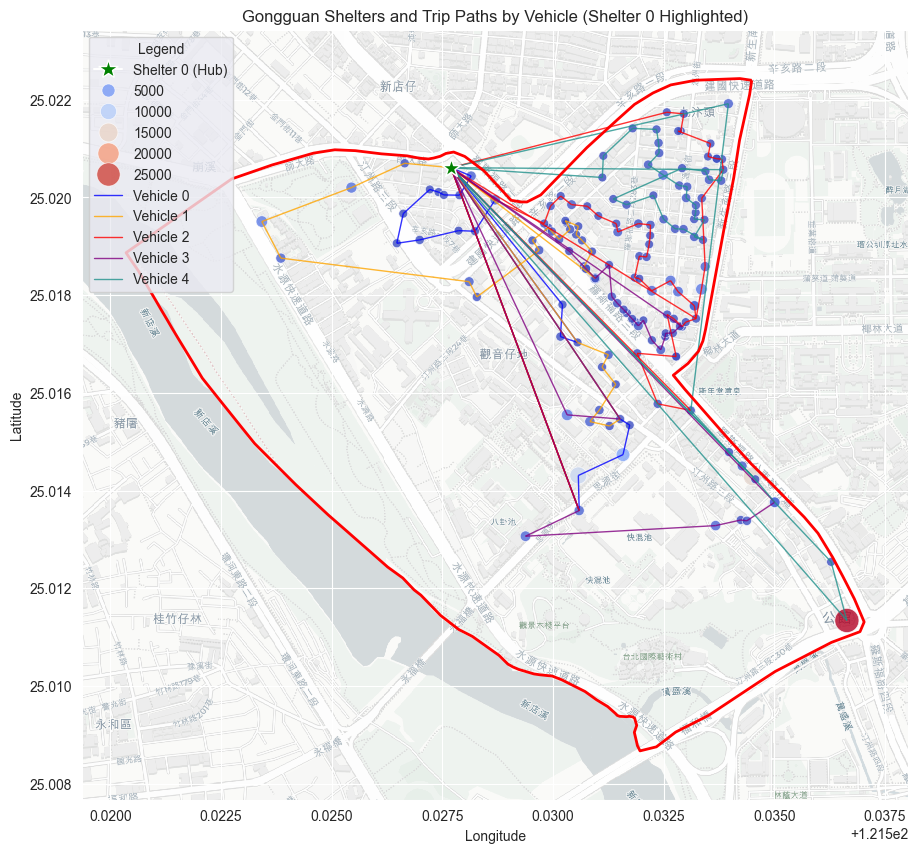

Number of valid trip legs plotted: 178


In [8]:
import pandas as pd
import shapely.geometry as geom
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

########################

# Make sure you have df_shelters_gongguan from previous cells
# It should contain the shelters within the Gongguan polygon

# Load the trip records data
df_trips = pd.read_csv('routes_flat.csv')

# Assuming df_shelters_gongguan is already filtered and reset index from previous steps
# Ensure df_shelters_gongguan is indexed from 0
# This is important because the indices in shelters_visited refer to this DataFrame's index
df_shelters_gongguan = df_shelters_gongguan.reset_index(drop=True)

# Function to get shelter coordinates by index from the gongguan DataFrame
def get_shelter_coords_by_index(shelter_index):
    # Check if the index is valid for df_shelters_gongguan
    if shelter_index is not None and 0 <= shelter_index < len(df_shelters_gongguan):
        return df_shelters_gongguan.loc[shelter_index, 'Longitude'], df_shelters_gongguan.loc[shelter_index, 'Latitude']
    return None, None # Return None if index is out of bounds or None

# Create a list to store data for each trip leg
trip_legs_data = []

# Process each trip to extract legs (origin-destination pairs)
for index, row in df_trips.iterrows():
    shelter_indices_str = row['shelters_visited']
    # Split the string by ';' to get individual shelter indices
    shelter_indices = [int(idx.strip()) for idx in shelter_indices_str.split(';') if idx.strip().isdigit()]

    # **MODIFICATION START**
    # Add the hub (shelter 0) at the beginning and end of the sequence if it's not already there
    full_trip_indices = [0] + shelter_indices + [0]
    # **MODIFICATION END**

    # Create trip legs: from index i to index i+1
    for i in range(len(full_trip_indices) - 1): # Use full_trip_indices now
        origin_index = full_trip_indices[i]
        destination_index = full_trip_indices[i+1]

        # Get coordinates for origin and destination
        origin_lon, origin_lat = get_shelter_coords_by_index(origin_index)
        destination_lon, destination_lat = get_shelter_coords_by_index(destination_index)

        # Add trip leg data if both origin and destination coordinates are valid
        if origin_lon is not None and destination_lon is not None:
             trip_legs_data.append({
                'trip_id': row['trip_id'],
                'vehicle_id': row['vehicle_id'],
                'origin_shelter_index': origin_index,
                'destination_shelter_index': destination_index,
                'Origin Lon': origin_lon,
                'Origin Lat': origin_lat,
                'Destination Lon': destination_lon,
                'Destination Lat': destination_lat,
            })

# Create a DataFrame from the trip legs data
df_trip_legs = pd.DataFrame(trip_legs_data)

# Convert trip coordinates to GeoDataFrame for plotting lines
trip_lines = []
for index, row in df_trip_legs.iterrows():
    origin_point = geom.Point(row['Origin Lon'], row['Origin Lat'])
    dest_point = geom.Point(row['Destination Lon'], row['Destination Lat'])
    trip_line = geom.LineString([origin_point, dest_point])
    trip_lines.append(trip_line)

gdf_trip_legs = gpd.GeoDataFrame(df_trip_legs, geometry=trip_lines, crs="EPSG:4326")

# --- Plotting the map with shelter points and trip paths ---
plt.figure(figsize=(12, 10))
ax = plt.gca()

# Optional: Plot all shelters (light grey, small)
# sns.scatterplot(
#     data=points_gdf, x='Longitude', y='Latitude',
#     color='lightgrey', s=10, alpha=0.4, ax=ax, legend=False
# )

# Gongguan-only shelters (blue, sized by capacity) - Use gdf_gongguan_pts
# Ensure gdf_gongguan_pts is available from the previous cell
if 'gdf_gongguan_pts' in globals():
    gdf_gongguan_pts = gdf_gongguan_pts.reset_index(drop=True)

if 'gdf_gongguan_pts' in locals():
    # Separate shelter 0
    shelter_0 = gdf_gongguan_pts[gdf_gongguan_pts.index == 0]
    other_shelters = gdf_gongguan_pts[gdf_gongguan_pts.index != 0]

    # Plot other shelters (sized by capacity)
    sns.scatterplot(
        data=other_shelters, x='Longitude', y='Latitude',
        size='Capacity', hue='Capacity',
        palette='coolwarm', sizes=(40, 300), alpha=0.8, ax=ax, legend=True # Keep legend for capacity
    )

    # Plot shelter 0 with a distinct color and possibly larger size/marker
    sns.scatterplot(
        data=shelter_0, x='Longitude', y='Latitude',
        color='green', # Choose a distinct color, e.g., green
        s=200,        # Choose a distinct size
        marker='*',   # Choose a distinct marker
        alpha=1.0,
        ax=ax,
        legend=False,  # Don't need a separate legend entry for just one point here
        label='Shelter 0 (Hub)', # Add label for legend later if needed
        zorder=10,
    )
    # Manually create a legend handle for Shelter 0 if you want it in the legend
    from matplotlib.lines import Line2D
    shelter_0_legend_handle = Line2D([0], [0], marker='*', color='w', label='Shelter 0 (Hub)',
                                      markerfacecolor='green', markersize=15)


else:
     print("Warning: gdf_gongguan_pts not found. Shelter points will not be plotted.")


# Plot the trip paths, colored by vehicle_id
if 'gdf_trip_legs' in locals() and not gdf_trip_legs.empty:
    # **MODIFICATION START**
    # Define a custom palette or select distinct colors
    custom_palette = {
        0: 'blue',      # Vehicle 0 in blue
        1: 'orange',    # Vehicle 1 in orange
        2: 'red',       # Vehicle 2 in red
        3: 'purple'     # Vehicle 3 in purple
        # Add more vehicles and colors as needed
    }

    # Get the number of unique vehicles in your data
    unique_vehicles_in_data = sorted(gdf_trip_legs['vehicle_id'].unique())

    # Create a palette ensuring all vehicles in the data have a color
    # Use custom colors for specified vehicles, fall back to a different palette for others
    vehicle_palette = {}
    fallback_colors = sns.color_palette('viridis', n_colors=len(unique_vehicles_in_data) - len(custom_palette)) # Use a different palette for fallback

    fallback_color_index = 0
    for vehicle_id in unique_vehicles_in_data:
        if vehicle_id in custom_palette:
            vehicle_palette[vehicle_id] = custom_palette[vehicle_id]
        else:
            # Assign fallback color if not in custom palette
            vehicle_palette[vehicle_id] = fallback_colors[fallback_color_index]
            fallback_color_index += 1

    # **MODIFICATION END**

    # Plot all trip legs using the GeoDataFrame gdf_trip_legs
    gdf_trip_legs.plot(ax=ax, color=gdf_trip_legs['vehicle_id'].map(vehicle_palette), linewidth=1, alpha=0.8, legend=False) # Set legend to False here to manually build it later

    # Create a custom legend for the trip paths by vehicle
    vehicle_legend_handles = []
    for vehicle_id, color in vehicle_palette.items(): # Use the generated vehicle_palette
        line = plt.Line2D([], [], color=color, linewidth=1, alpha=0.8, label=f'Vehicle {vehicle_id}') # Match linewidth
        vehicle_legend_handles.append(line)

    # Combine the seaborn legend (for shelter capacity) with the vehicle and vehicle legend
    handles, labels = ax.get_legend_handles_labels()

    # Filter out the default 'Trip Paths by Vehicle' and potentially the default scatterplot label if it somehow appeared
    filtered_handles = [h for h, l in zip(handles, labels) if l not in ['Trip Paths by Vehicle', 'Shelter 0 (Hub)']]
    filtered_labels = [l for l in labels if l not in ['Trip Paths by Vehicle', 'Shelter 0 (Hub)']]


    # Add shelter 0 legend handle if it was created
    if 'shelter_0_legend_handle' in locals():
         combined_handles = [shelter_0_legend_handle] + filtered_handles + vehicle_legend_handles
         combined_labels = [shelter_0_legend_handle.get_label()] + filtered_labels + [h.get_label() for h in vehicle_legend_handles]
    else:
         combined_handles = filtered_handles + vehicle_legend_handles
         combined_labels = filtered_labels + [h.get_label() for h in vehicle_legend_handles]


    # Update the legend with combined handles and labels
    ax.legend(combined_handles, combined_labels, loc='upper left', frameon=True, title='Legend')

else:
     print("Warning: gdf_trip_legs is not defined or empty. Trip paths will not be plotted.")


# Plot Gongguan polygon outline
if 'gongguan_gdf' in locals():
    gongguan_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Gongguan boundary')
else:
    print("Warning: gongguan_gdf not found. Gongguan boundary will not be plotted.")


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Gongguan Shelters and Trip Paths by Vehicle (Shelter 0 Highlighted)")

# --- Set map boundaries ---
if 'gongguan_poly' in locals():
    minx, miny, maxx, maxy = gongguan_poly.bounds
    pad = 0.001
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
else:
     print("Warning: gongguan_poly not found. Map boundaries may not be set correctly.")


# --- Add basemap ---
if 'ctx' in locals():
    tile_url = "https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}@2x.png"
    ctx.add_basemap(ax, source=tile_url, crs="EPSG:4326")

    for im in ax.get_images():
        im.set_interpolation('nearest')
else:
    print("Warning: contextily not imported. B4asemap will not be added.")


plt.savefig("gongguan_shelters_trips_by_vehicle_hub.png", dpi=500, bbox_inches='tight')
plt.show()

print(f"Number of valid trip legs plotted: {len(gdf_trip_legs) if 'gdf_trip_legs' in locals() else 0}")

In [1]:
!jupyter nbconvert --to html Data-Collection-Pipeline.ipynb

[NbConvertApp] Converting notebook Data-Collection-Pipeline.ipynb to html
[NbConvertApp] Writing 361400 bytes to Data-Collection-Pipeline.html
